In [1]:
#回归任务
#特征：单价、评论数、好评率、控制类型、售后服务、类型
#目标：预测销量
#精准度不做特别高的要求
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error,r2_score
data=pd.read_csv('C:/Users/86156/Desktop/生产实习/数据/jd_product_info.csv',
                 index_col=0)
#特征工程
#单价
#检查是否有空数据
data['price'].isnull().sum()

0

In [2]:
#评论数求和
data['comment_value']=data[['score1Count','score2Count','score3Count',
                           'score4Count','score5Count']].sum(axis=1)#按行求和
#好评率
data['favorable_rate']=data['score5Count']/data['comment_value']
data['favorable_rate'].isnull().sum()#存在0/0的不合理计算

6

In [3]:
#对空值填充0
data['favorable_rate'].fillna(value=0,inplace=True)
#检查控制类型的数据
data['controlMode'].unique()
#怎样处理
control_list=[]
for i in data['controlMode'].unique():
    control_list+=(str(i).split('，'))
control_list=list(set(control_list))
#判断有没有控制说明，有就标1，没有标0
#先假设都有数据
data['controlMode_YN']=1
#把判断空数据的布尔值作为行索引，赋值0
data.loc[data['controlMode'].isnull(),'controlMode_YN']=0
#十个类型，有标1，没有0
#先留出来十个类型的空间
data[control_list]=0
for id in data.index:
    #获取控制类型的列表
    col_list=str(data.loc[id,'controlMode']).split(',')
    #将列表作为列索引进行赋值
    data.loc[id,col_list]=1
data['control_num']=data[control_list].sum(axis=1)
#售后服务
data['service_yn']=1
data.loc[data['service'].isnull(),'service_yn']=0
#类型处理
#处理空数据，填充
data['type'].fillna(value='其他',inplace=True)
type_dict={item:i for i,item in enumerate(data['type'].unique())}
data['type']=data['type'].map(type_dict)#不要单独重复运行
#销量转成数字
#先转换带文字和+的
def fun(i):
    if '万+' in i:
        i=i.replace('万+','')
        i=int(i)*10000
    elif '+' in i:
        i=i.replace('+','')
        i=int(i)
    else: i=int(i)
    return i
#再转换数字
data['saleVolume']=data['saleVolume'].map(fun)

In [4]:
#map适用于一对一的关系
#替换成agg，可以和分组聚合使用，只能返回一个结果
#apply，和分组聚合使用，使用lambda定义简单函数
#建模处理
#数据集分割
#筛选xy
Y=data['saleVolume']
feature_list=['price','type', 'service_yn','control_num','favorable_rate','comment_value']
X=data[feature_list]
# 分割数据集
train_x,test_x,train_y,test_y=train_test_split(X,Y)
X.isnull().sum()  # 检查有没有空值，没有空值，就可以进行下一步

price             0
type              0
service_yn        0
control_num       0
favorable_rate    0
comment_value     0
dtype: int64

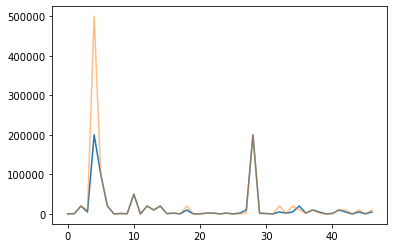

In [11]:
#建模预测
model=DecisionTreeRegressor().fit(train_x,train_y)
prey=model.predict(test_x)
mean_absolute_error(test_y,prey)

r2_score(test_y,prey)

import matplotlib.pyplot as plt
plt.plot(np.arange(len(prey)),prey)
plt.plot(np.arange(len(prey)),test_y,alpha=0.5)

<AxesSubplot:>

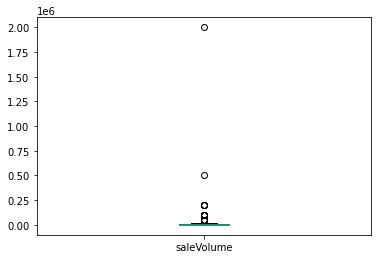

In [12]:
#改进
#拟合度不高，处理噪声数据
#第一种处理方法：箱型图
#手动设置阈值，删除特别大的数
data['saleVolume'].plot.box()

3008.2608695652175 0.9415192322256555


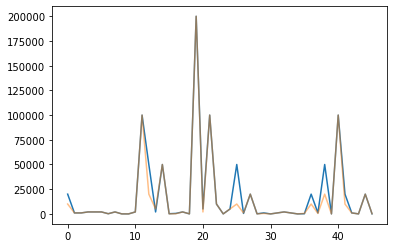

In [13]:
# 先尝试去掉两个数据,最终：保留小于250000的数 (来源于直方图)
index=data['saleVolume']<250000
Y=data.loc[index,'saleVolume']
X=data.loc[index,feature_list]
# 分割数据集
train_x,test_x,train_y,test_y=train_test_split(X,Y)
model=DecisionTreeRegressor().fit(train_x,train_y)
prey=model.predict(test_x)
print(mean_absolute_error(test_y,prey),r2_score(test_y,prey))
import matplotlib.pyplot as plt
plt.plot(np.arange(len(prey)),prey)
plt.plot(np.arange(len(prey)),test_y,alpha=0.5)

In [14]:
#噪声值处理的第二种方法：利用分布进行筛选，
#适合噪声值比较少且差异大，其他数据分布密集的情况
#本次测试删除数据太多
ans=data[['saleVolume']].describe()
# 根据分布区间获取最小值和最大值
max_value=ans.values[5]+ans.values[6]*2
min_value=ans.values[5]-ans.values[4]*2
min_value,max_value

(array([1000.]), array([22000.]))

此时有99样本
1000.0 0.8785822021116139


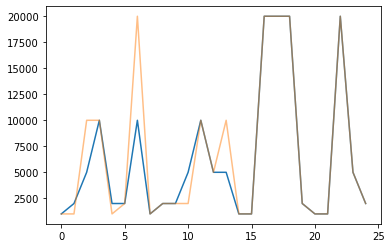

In [15]:
# 根据前面的数，修改索引
index=(data['saleVolume']<=max_value[0]) & (data['saleVolume']>=min_value[0])
Y=data.loc[index,'saleVolume']
X=data.loc[index,feature_list]
print(f'此时有{sum(index)}样本')
# 分割数据集
train_x,test_x,train_y,test_y=train_test_split(X,Y)
model=DecisionTreeRegressor().fit(train_x,train_y)
prey=model.predict(test_x)
print(mean_absolute_error(test_y,prey),r2_score(test_y,prey))
import matplotlib.pyplot as plt
plt.plot(np.arange(len(prey)),prey)
plt.plot(np.arange(len(prey)),test_y,alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

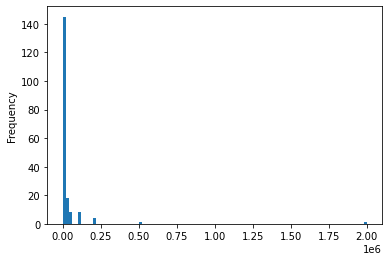

In [16]:
#第三种：机器学习方法
#通过密度聚类
data['saleVolume'].plot.hist(bins=100)  #二八分

此时有169样本
3297.6744186046512 0.9298716448165867


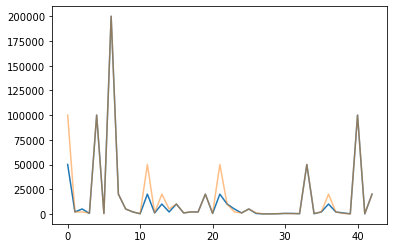

In [17]:
from sklearn.cluster import DBSCAN
Dmodel=DBSCAN(min_samples=2,# 领域内容纳的最小的样本数
             ) 
# 把数据变成两维的
Y=data['saleVolume'].values.reshape(-1,1)
Dmodel.fit(Y)
# 查看识别出的噪声点有多少个
sum(Dmodel.labels_==-1)
# 找到所有的噪点的索引
index=Dmodel.labels_==-1
# 对噪声点的索引取反：~index
Y=data.loc[~index,'saleVolume']
X=data.loc[~index,feature_list]
print(f'此时有{sum(~index)}样本')
# 分割数据集
train_x,test_x,train_y,test_y=train_test_split(X,Y)
model=DecisionTreeRegressor().fit(train_x,train_y)
prey=model.predict(test_x)
print(mean_absolute_error(test_y,prey),r2_score(test_y,prey))
import matplotlib.pyplot as plt
plt.plot(np.arange(len(prey)),prey)
plt.plot(np.arange(len(prey)),test_y,alpha=0.5)

In [18]:
#模型解释
#从各因子的重要程度得出是否需要删除部分特征
#数字越大越重要，别看漏了后面的e
model.feature_importances_

array([1.48080883e-03, 2.95049380e-03, 6.22224304e-04, 4.15695688e-04,
       6.89906184e-03, 9.87631716e-01])

In [ ]:
#结论
#不同的特征数据得到的结果不同，没有绝对的正确，多自己尝试